## Activation Regions for animals classification

In [1]:
import pandas as pd

data = pd.read_csv('../dataset/animals.csv')
data.head()

,Unnamed: 0,Animal Name,Description,Classification
0,0,Boa constrictor,the boa constrictor boa constrictor is a large...,Reptile
1,1,Common carp,the common carp cyprinus carpio is a widesprea...,Fish
2,2,Python regius,they are also known as royal pythons or ball p...,Reptile
3,3,Brown rat,the brown rat common rat sewer rat hanover rat...,Land Mammal
4,4,Black mamba,no description found,Reptile


Removing rows with empty description

In [2]:
print(f"Previous shape: {data.shape}")
[data.drop(i, inplace=True) for i in range(len(data['Description'])) if type(data["Description"][i]) != str]
print(f"New shape: {data.shape}")

Previous shape: (166, 4)
New shape: (163, 4)


Turning our dataset into HuggingFace-style Dataset

In [3]:
from datasets import Dataset, ClassLabel

unique_classes = data['Classification'].unique()

# Create a Hugging Face Dataset with the 'Classification' column as ClassLabel
animals = Dataset.from_pandas(data)
class_label = ClassLabel(names=list(unique_classes))

# Update the dataset to have the 'Classification' column as ClassLabel
animals = animals.cast_column('Classification', class_label)
animals = animals.rename_column('Classification', 'label')
animals = animals.rename_column('Description', 'text')
animals = animals.rename_column('Animal Name', 'name')


/home/lipecorradini/.cache/pypoetry/virtualenvs/llm-mri-RE74i_Ji-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Casting the dataset: 100%|██████████| 163/163 [00:00<00:00, 26696.53 examples/s]


In [4]:
model_ckpt = "distilbert-base-uncased"

Removing columns not associated with the "text" (description of the animal) or the "label" (classification of the animal)

In [5]:
for column in animals.features:
    if(column not in ["text", "label"]):
        animals = animals.remove_columns(column)

In [6]:
from llm_mri import LLM_MRI
llm_mri = LLM_MRI(model=model_ckpt, device="cpu", dataset=animals)

Map: 100%|██████████| 163/163 [00:00<00:00, 5559.12 examples/s]


### Activation Areas

Processing the activation areas by reducing the model's dimensionality

In [7]:
llm_mri.process_activation_areas(map_dimension = 10)

Map: 100%|██████████| 163/163 [00:38<00:00,  4.18 examples/s]


### Layer Image

Visualizing the model's activations through a 10x10 grid.
First, we can evaluate how does the activation on the first layer are disposed:

In [8]:
import matplotlib.pyplot as plt


def see_layer_activation(layer:int):
    for category in data['Classification'].unique():
        figure = llm_mri.get_layer_image(layer=layer, category=category)
        plt.tight_layout()
        plt.show()

# see_layer_activation(1)

We can see how do the grids change as we move to the third layer of the model:

In [9]:
# see_layer_activation(3)

Now, we can see the activations for the last layer of the model:

In [10]:
# see_layer_activation(6)

By looking at the last activations, we can see that, as deeper layers get more specific, categories narrow down their activation regions to those that represent better the defined category.

For example, on the first layer for the "Bird" category, activations were mostly even spread out through the grid. However, on the last layer, most of the activations were concentrated on a certain point, indicating that this region might be identifying attributes on the text mostly related to birds.

### Graph representation

Here, we can see how different categories interacted with similar regions through a graph visualization. On this example, we can see which regions were activated by "Fish" texts, by "Aquatic Mammal" texts, and also by both of those.

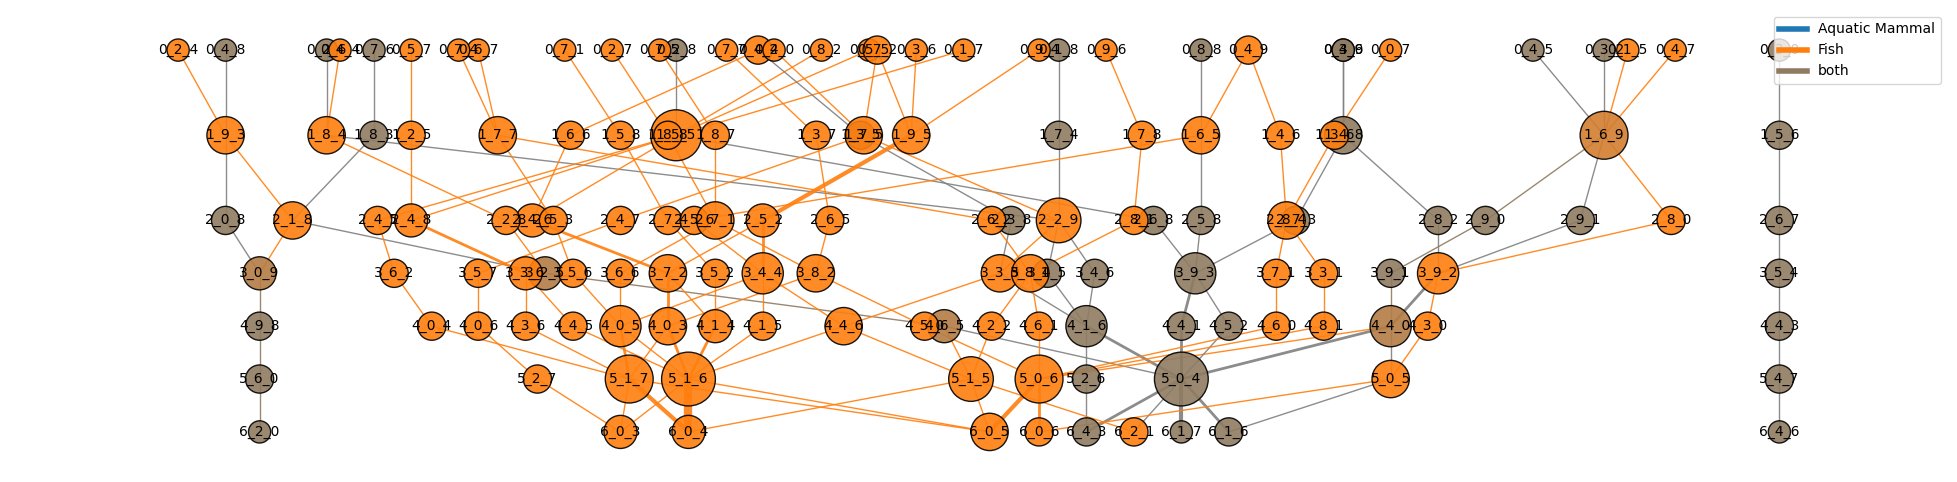

In [11]:
all_graph = llm_mri.get_composed_graph("Aquatic Mammal", "Fish")
all_graph_image = llm_mri.get_graph_image(all_graph)


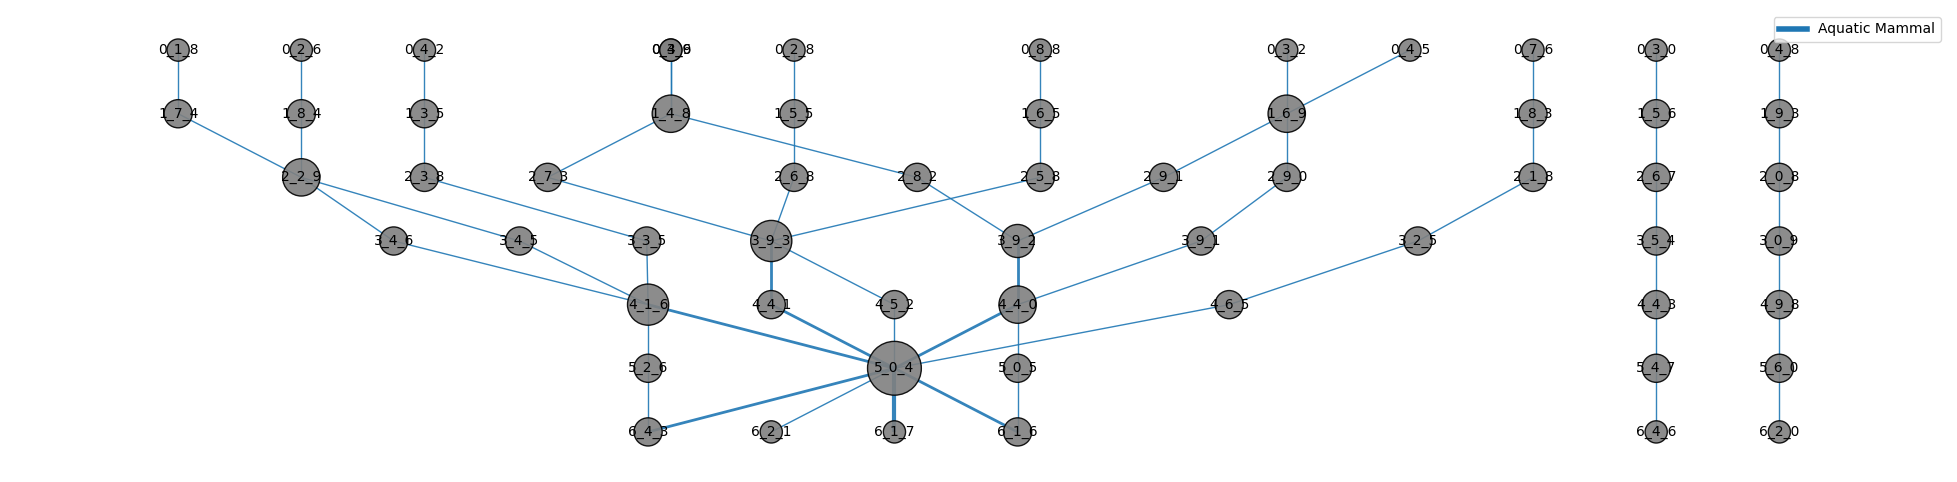

In [12]:
all_graph = llm_mri.get_graph("Aquatic Mammal")
all_graph_image = llm_mri.get_graph_image(all_graph)


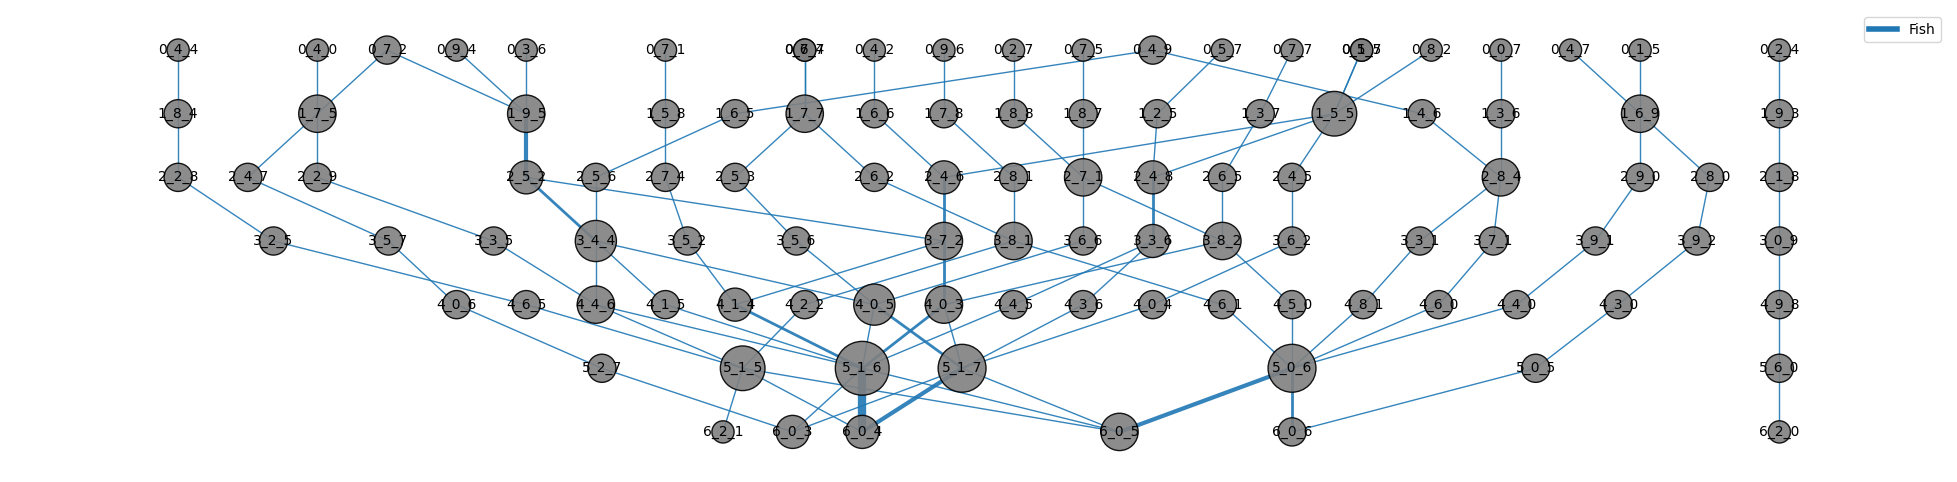

In [13]:
all_graph_1 = llm_mri.get_graph("Fish")
all_graph_image_1 = llm_mri.get_graph_image(all_graph_1)